# implement line sweeps of params
- all params fixed expcet one, which is swept over range
- specifically looking at test accuracy as a function of one param


In [57]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product

import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
from glob import glob as glob
gsname = "gs0828"
L = []
for fp in glob('data/'+gsname+'/*'):
  df_ = pd.read_csv(fp)
  L.append(df_)
gsdf = pd.concat(L)
gsdf.to_csv('data/gsdf-'+gsname+'.csv')

In [59]:
gsdf.loc[:,'mi'] = gsdf.middle-gsdf.interleaved
gsdf.loc[:,'bi'] = gsdf.blocked-gsdf.interleaved
gsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late,mi,bi
0,0,290.0,600,557.5,0.95,0.0,1.0,1.0,1.0,0.923531,0.508554,0.695649,0.585023,0.519637,0.076469,0.414977
1,1,290.0,610,557.5,0.95,0.0,1.0,1.0,1.0,0.907513,0.491697,0.808202,0.565669,0.508509,0.073972,0.415815
2,2,290.0,620,557.5,0.95,0.0,1.0,1.0,1.0,0.904559,0.496422,0.794853,0.558656,0.491371,0.062234,0.408137
3,3,290.0,630,557.5,0.95,0.0,1.0,1.0,1.0,0.945539,0.489787,0.789133,0.579287,0.509367,0.089501,0.455752
4,4,290.0,640,557.5,0.95,0.0,1.0,1.0,1.0,0.957492,0.504422,0.806593,0.566966,0.499678,0.062543,0.453070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,6,300.0,660,450.0,1.15,0.0,1.0,1.0,1.0,0.962848,0.497353,0.831556,0.593089,0.505475,0.095736,0.465495
7,7,300.0,670,450.0,1.15,0.0,1.0,1.0,1.0,0.959775,0.478528,0.750871,0.589541,0.509201,0.111014,0.481248
8,8,300.0,680,450.0,1.15,0.0,1.0,1.0,1.0,0.990000,0.480645,0.822138,0.526138,0.494469,0.045494,0.509356
9,9,300.0,690,450.0,1.15,0.0,1.0,1.0,1.0,0.980047,0.502038,0.868470,0.624202,0.496208,0.122164,0.478008


In [62]:
BI = gsdf.blocked>0.9
MI = gsdf.mi>0.18
gsdf[BI&MI]

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late,mi,bi
3,3,296.0,630,525.0,0.95,0.0,1.0,1.0,1.0,0.905330,0.492617,0.741076,0.679952,0.516716,0.187335,0.412714
3,3,306.0,630,472.5,0.95,0.0,1.0,1.0,1.0,0.951938,0.482129,0.753261,0.664577,0.516342,0.182448,0.469809
3,3,294.0,630,460.0,0.95,0.0,1.0,1.0,1.0,0.934984,0.479091,0.761637,0.668002,0.532337,0.188911,0.455893


In [63]:
A = gsdf.blocked > 0.9
MI = gsdf.mi > 0.1
I = gsdf.interleaved < .65
L = gsdf.late > 0.55
df = gsdf[A&MI&I].sort_values('mi',ascending=False)
df

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late,mi,bi
3,3,294.0,630,460.0,0.95,0.0,1.0,1.0,1.0,0.934984,0.479091,0.761637,0.668002,0.532337,0.188911,0.455893
3,3,296.0,630,525.0,0.95,0.0,1.0,1.0,1.0,0.905330,0.492617,0.741076,0.679952,0.516716,0.187335,0.412714
3,3,306.0,630,472.5,0.95,0.0,1.0,1.0,1.0,0.951938,0.482129,0.753261,0.664577,0.516342,0.182448,0.469809
4,4,300.0,640,455.0,0.95,0.0,1.0,1.0,1.0,0.906407,0.484785,0.711895,0.663920,0.504059,0.179135,0.421622
4,4,300.0,640,492.5,1.15,0.0,1.0,1.0,1.0,0.942982,0.509046,0.767262,0.687229,0.508806,0.178182,0.433936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,6,298.0,660,490.0,0.95,0.0,1.0,1.0,1.0,0.938236,0.493938,0.776145,0.593985,0.513292,0.100047,0.444298
1,1,302.0,610,530.0,1.05,0.0,1.0,1.0,1.0,0.933439,0.487549,0.774694,0.587581,0.507463,0.100032,0.445890
7,7,296.0,670,482.5,1.05,0.0,1.0,1.0,1.0,0.948174,0.492704,0.767968,0.592721,0.507855,0.100017,0.455470
4,4,290.0,640,582.5,0.95,0.0,1.0,1.0,1.0,0.902477,0.490555,0.782277,0.590563,0.491412,0.100009,0.411922


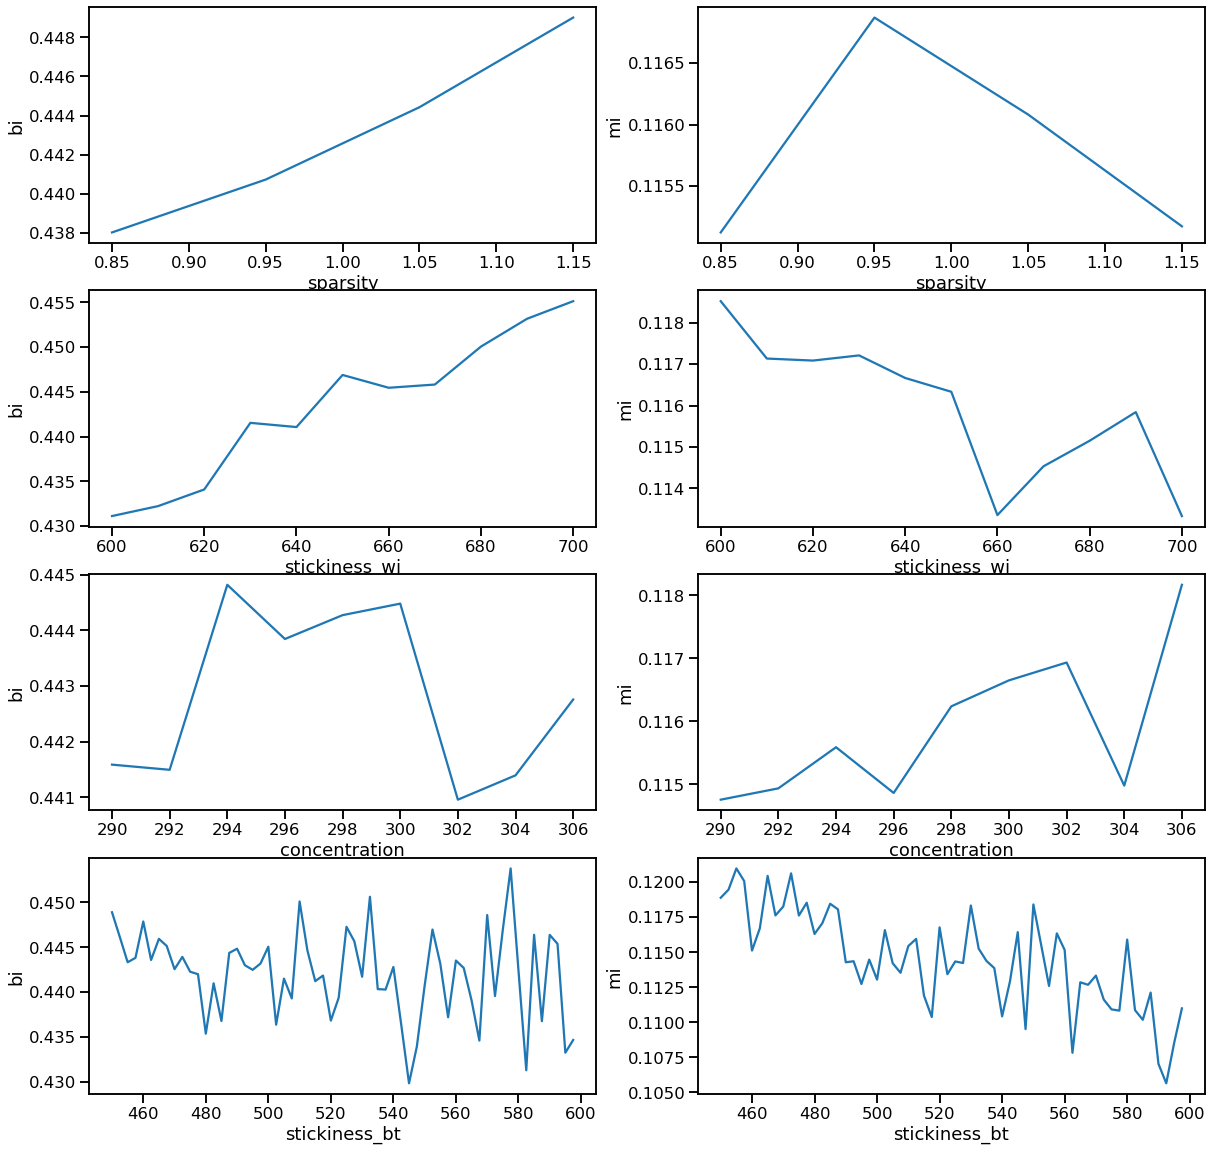

In [64]:
xparams = ['sparsity','stickiness_wi','concentration','stickiness_bt']
varL = ['bi','mi']
f,axar = plt.subplots(4,2,figsize=(20,20))
for xidx in range(4):
  for vidx in range(2):
    var = varL[vidx]
    param = xparams[xidx]
    ax=axar[xidx,vidx]
    ax.plot(df.groupby(param).mean().loc[:,var])
    ax.set_ylabel(var)
    ax.set_xlabel(param)

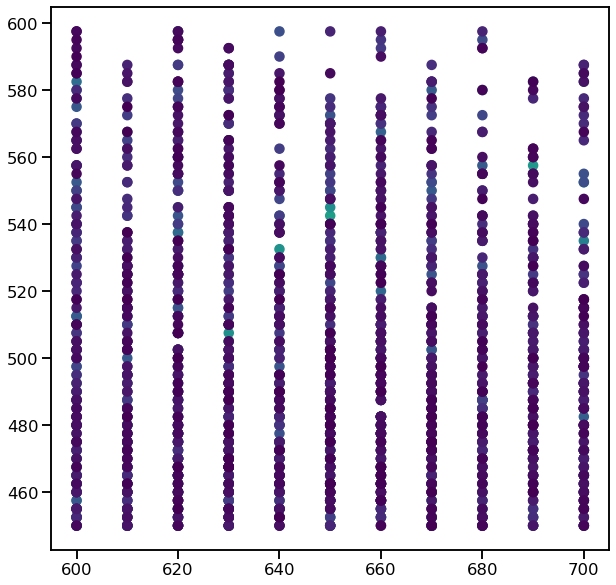

In [65]:
plt.figure(figsize=(10,10))
plt.scatter(df.stickiness_wi,df.stickiness_bt,c=df.mi)

Text(0.5, 1.0, 'gsdf0825\ncolor indicates betawi')

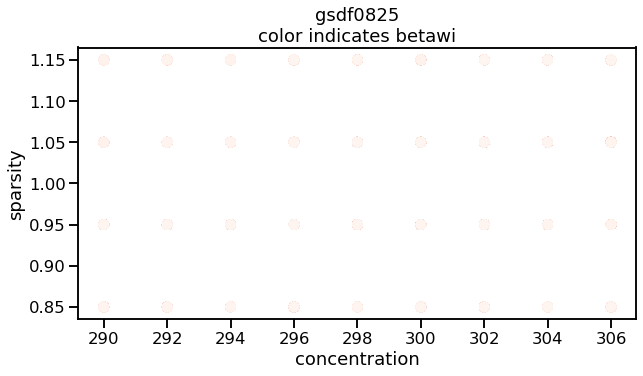

In [66]:
f,ax=plt.subplots(1,1,figsize=(10,5))
# df = gsdf
X = gsdf.stickiness_bt>6
df = gsdf[A&MI&I&X].sort_values('mi',ascending=False)

ax.scatter(df.concentration,df.sparsity,c=df.mi,cmap='Reds')
ax.set_xlabel('concentration')
ax.set_ylabel('sparsity')
ax.set_title('gsdf0825\ncolor indicates betawi')
# plt.savefig('figures/gsdf0825-sparsity-vs-concentration')

Text(0.5, 1.0, 'gsdf0825\ncolor indicates betawi')

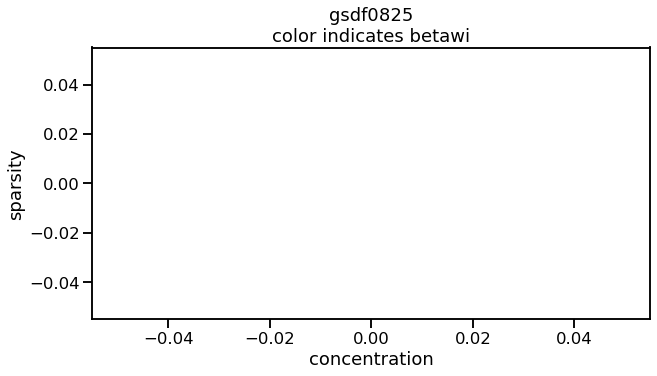

In [61]:
f,ax=plt.subplots(1,1,figsize=(10,5))
# df = gsdf
cL = ['Greens','Reds']
pname = 'stickiness_wi'
pval = [3500,5000]
for idx in range(2):
  df_ = df[df.loc[:,pname] == pval[idx]]
  ax.scatter(df_.concentration,df_.sparsity,c=df_.mi,cmap=cL[idx])
ax.set_xlabel('concentration')
ax.set_ylabel('sparsity')
ax.set_title('gsdf0825\ncolor indicates betawi')
# plt.savefig('figures/gsdf0825-sparsity-vs-concentration')

Text(0.5, 1.0, 'gsdf0825\ncolor indicates betawi')

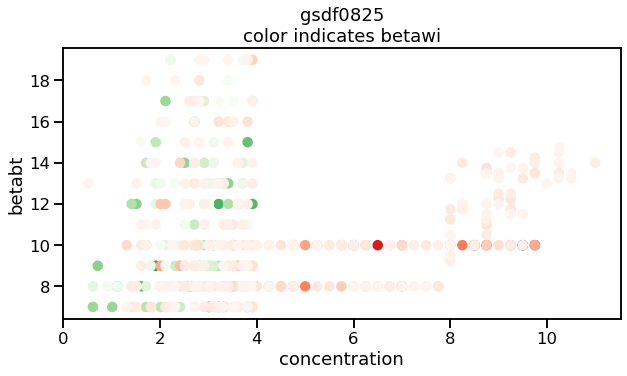

In [8]:
f,ax=plt.subplots(1,1,figsize=(10,5))

cL = ['Greens','Reds']
pname = 'stickiness_wi'
pval = [3500,5000]
for idx in range(2):
  df_ = df[df.loc[:,pname] == pval[idx]]
  ax.scatter(df_.concentration,df_.stickiness_bt,c=df_.mi,cmap=cL[idx])
ax.set_xlabel('concentration')
ax.set_ylabel('betabt')
ax.set_title('gsdf0825\ncolor indicates betawi')
# plt.savefig('figures/gsdf0825-sparsity-vs-concentration')